# Lab:  Nonlinear Least-Squares

In this lab, we will explore gradient descent for nonlinear least squares.  Our goal is to fit a nonlinear model of the form

$$y \approx f(x,\mathbf{w})$$
     
where $x$ is a scalar feature, $\mathbf{w}$ is a vector of parameters and $f$ is a nonlinear function of $x$ and $\mathbf{w}$.
To do this, we will seach for the parameters $\mathbf{w}$ that minimize the RSS cost

$$J(\mathbf{w}) = \sum_i (y_i - f(x_i,\mathbf{w}))^2$$
     
summed over training samples $(x_i,y_i)$.  This problem is known as nonlinear least-squares (NLLS).  In general, this optimization problem has no closed-form expression, and so gradient descent is widely used.  

In this lab, we will apply NLLS to a dataset from the National Institute of Standards.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets appropriate for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [216]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot `y` vs. `x`.

Text(0, 0.5, 'Temperature y (K)')

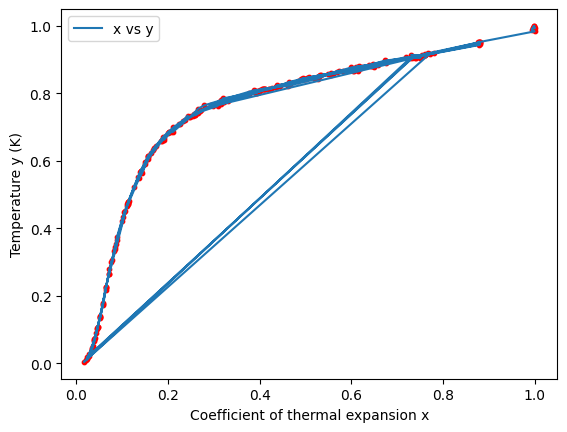

In [217]:
# TODO
x0 = df['x0'].values
y0 = df['y0'].values
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.scatter(x,y,s=10,c='r')
#plt.plot(np.sort(x),np.sort(y),label='x vs y')
plt.plot(x,y,label='x vs y')
plt.legend()
plt.xlabel('Coefficient of thermal expansion x')
plt.ylabel('Temperature y (K)')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

<ipython-input-218-de2b396f5e53>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Temperature yn (K)')

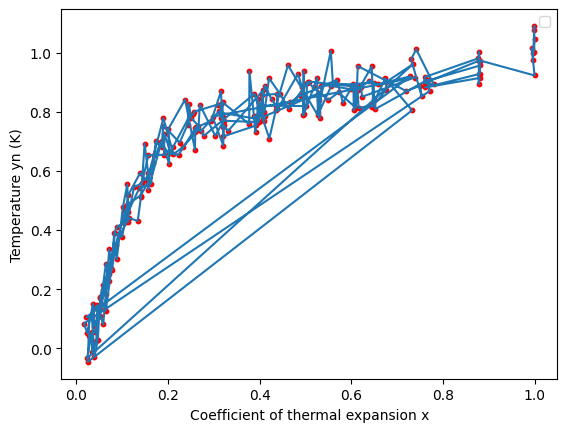

In [218]:
# TODO
yn = y + np.random.normal(0,0.05,len(y))
plt.scatter(x,yn,s=10,c='r')
plt.plot(x,yn)
#plt.plot(np.sort(x),np.sort(yn),label='x vs yn')
plt.legend()
plt.xlabel('Coefficient of thermal expansion x')
plt.ylabel('Temperature yn (K)')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [219]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33,random_state=10)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

$$y\approx f(x,\mathbf{w}) = \frac{a_0 + a_1 x + ... + a_d x^d}{1 + b_0 x + ... + b_{d-1} x^d}$$
      
with $d=3$.  The model parameters are $\mathbf{w} = [a_0,...,a_d,b_0,...,b_{d-1}]^\top$, so there are $2d+1$ parameters total.    Complete the function below that takes vectors `w` and `x` and computes the predictions $\hat{y}=f(x,\mathbf{w})$ using the above model.
   

In [220]:
#def predict(w,x):

    # Extract the model order
    # d = ...

    # TODO.  Extract a and b from w
    # a = ...
    # b = ...

    # TODO.  Compute the numerator of f(x,w) using x and a
    # Xnum =
    # num =

    # TODO.  Compute the denominator of f(x,w) using x and b
    # Xden =
    # den =

    # combine numerator and denominator to obtain yhat = f(x,w)
    # yhat =
def predict(w,x):
    d=int((len(w)-1)*0.5)
    #print(d)
    a=w[0:d+1]
    b=w[d+1:]
    ar=a[::-1]  #reversing array a for polyval function
    br=b[::-1]  #reversing array b for polyval function
    Xnum = np.polyval(ar,x) #numerator
    Xden = np.polyval(br,x) #denominator
    yhat = Xnum/(1+Xden)
    return yhat

## Parameter Initialization

When we fit with a nonlinear model, most methods only obtain convergence to a *local* minimum, which is not necessarily good.  To converge to the *global* minimum, we need a good initialization.  For a rational model, one way to get a good initialization is to use the following trick. First, realize that if

$$y \approx \frac{a_0 + a_1 x + ... + a_d x^d}{1 + b_0 x + ... + b_{d-1} x^d}$$
    
then, by rearranging, we get

$$y \approx a_0 + a_1 x + \dots + a_d x^d - b_0 x y - \dots - b_{d-1} x^d y.$$
    
Note that this latter model is not useful for *prediction* because it is predicting $y$ using $y$! But it *is* useful for fitting the parameters $\mathbf{w} = [a_0,...,a_d,b_0,...,b_{d-1}]^\top$ when $x$ and $y$ are known as training samples.  

Compute that fit using scikit-learn's `LinearRegression()` method by constructing a training matrix of the appropriate form using Numpy Broadcasting.  Depending on how you create this matrix, you may or may not want to use the intercept term in the `LinearRegression()` method.

As a hint, the $i$th row of the training matrix $\mathbf{Z}$ would have the following form if you are using the intercept term in the `LinearRegression()` method:

$$\mathbf{z}_i^\top = [ x_i, ... , x_i^d, -x_i y_i, ... , -x_i^d y_i ] .$$

As another hint, realize that a matrix with rows $[ x_i, x_i^2, ... , x_i^d]$ can be efficiently created using broadcasting as `xtr[:,None]**powd[None,:]`, where `xtr` contains $\{x_i\}_{i=1}^d$ and `powd = [1,...,d]`.  For more on broadcasting, see the demo in the first unit, especially the "outer product" section.  



In [221]:
# set model order
d = 3

# TODO.  Create the training matrix
# Ztr = ...

# TODO.  Fit with parameters with linear regression
# regr = LinearRegression()
# regr.fit(...)

# TODO.  Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# winit = ...

# TODO.  Print winit
powd=np.arange(1,d+1)
powd1=np.arange(1,d+1)
Ztr1=xtr[:,None]**powd[None,:]
Ztr2=-ytr[:,None]*(xtr[:,None]**powd1[None,:])
Ztr=np.hstack((Ztr1,Ztr2))
#print(Ztr)
regr = LinearRegression()
regr.fit(Ztr,ytr)
#winit=regr.coef_
winit = np.append(regr.coef_,regr.intercept_)
print(winit)

[  6.68071152 -23.07286716  17.89737118   1.12498577 -14.49262487
  13.74756452  -0.08045745]


Now using the `predict` function and your initial parameter estimate `winit`, compute `yhat` for 1000 values of $x$ uniformly spaced over the interval `[0,1]` that are stored in a vector called `xp`.  Plot `yhat` versus `xp`.  You should see that the prediction curve has some singularities (i.e., places where it goes to infinity).  On the same plot, superimpose the test samples `(xts,yts)`.  Use the `axis` command to zoom your plot into the region near the data samples.

(0.0, 1.0, -5.0, 5.0)

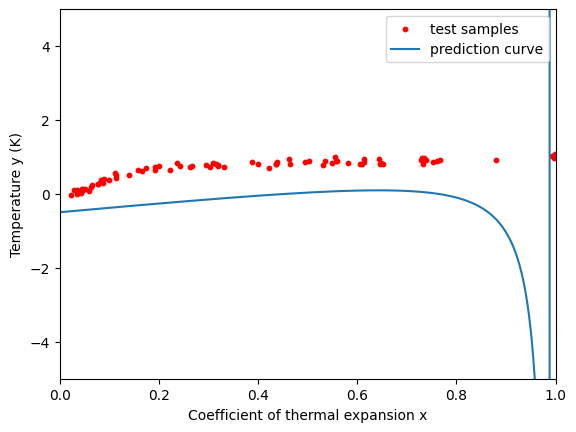

In [222]:
# TODO
# xp = ...
# yhat = ...
# plot(...)
xp=np.linspace(0,1,1000)
yhat=predict(winit,xp)
plt.scatter(xts,yts,s=10,label='test samples',c='r')
plt.plot(xp,yhat,label='prediction curve')
plt.legend()
plt.xlabel('Coefficient of thermal expansion x')
plt.ylabel('Temperature y (K)')
plt.axis([0,1,-5,5])

The problem with the prediction curve is that the denominator in our polynomial model for `yhat` goes to zero at certain values of `x` in `[0,1]`.  As a result, some of the `z` features become correlated, and the least-squares fit for `winit` includes relatively large coefficient values. To alleviate this problem, we can use Ridge regression instead of least-squares, in order to keep the `winit` parameters closer to zero.  Re-run the fit above with `Ridge` with `alpha = 2e-1`. You should see a much better (but not perfect) fit.

Text(0, 0.5, 'Temperature y (K)')

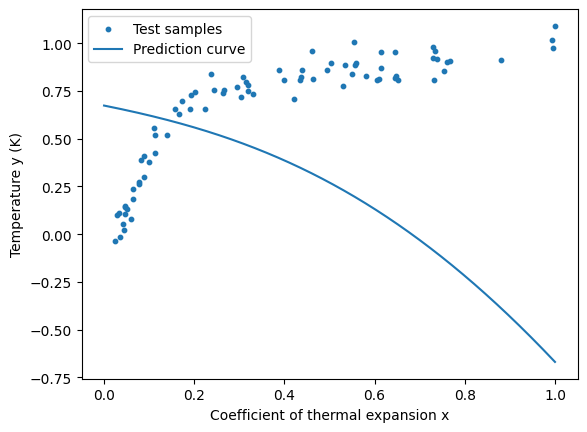

In [223]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=2e-1)
# regr.fit(...)

# TODO
# Extract and print the parameters from regr.coef_ and regr.intercept_
# winit = ...

# TODO
# Plot the results as above.
regr = Ridge(alpha=2e-1)
regr.fit(Ztr,ytr)
winit = np.append(regr.coef_,regr.intercept_)
#print(winit)
xp=np.linspace(0,1,1000)
yhat=predict(winit,xp)
plt.scatter(xts,yts,s=10,label='Test samples')
plt.plot(xp,yhat,label='Prediction curve')
plt.legend()
plt.xlabel('Coefficient of thermal expansion x')
plt.ylabel('Temperature y (K)')

## Computing the loss and gradient

We can now use gradient descent to improve our initial estimate `winit`.  Complete the construction of the following function, which is used to compute the RSS loss

$$J(\mathbf{w}) = \sum_{i=1}^n (y_i - f(x_i,\mathbf{w}))^2$$
    
and $\nabla J(\mathbf{w})$, the gradient of $J(\mathbf{w})$.  Your code should use Numpy broadcasting and matrix/vector multiplies as needed to avoid the use of "for" loops.  It should be written as efficiently as possible, so that no computations are repeated unnecessarily.

In [224]:
# class version
class Fun(object):
    def __init__(self,x,y,d):
        """
        The constructor takes in the training data and model order
        """
        # TODO. Compute Xnum and Xden as in the predict function
        # self.d = d
        # self.y = y
        # self.Xnum = ...
        # self.Xden = ...
        self.d=d
        self.y=y
        self.x=x
        darr=np.arange(0,d+1)
        darr1=np.arange(1,d+1)
        self.Xnum=x[:,None]**darr[None,:]
        self.Xden=x[:,None]**darr1[None,:]

    def Jeval(self,w):
        """
        The Jeval method computes the loss and gradient at w
        """
        # TODO. Compute a, b, num, den, and yhat, as in the predict function
        # a =
        # b =
        # num =
        # den =
        # yhat =

        # TODO.  Compute the training loss from yhat and y
        # J = ...

        # TODO.  Compute the gradients (see homework problem 1)
        # Jgrad = ...
        #d=self.d[-1]
        d=self.d
        a=w[0:d+1]
        b=w[d+1:]
        #print(self.Xnum.shape,self.Xden.shape,w,a,b)
        num = self.Xnum.dot(a)
        den = self.Xden.dot(b)
        yhat=num/(1+den)
        diff=self.y-yhat
        J=np.sum(diff**2)
        xarr=np.power(self.x,d)
        test=diff*yhat
        test1=diff.dot(xarr)
        #print(a.shape,b.shape,self.Xnum.shape)
        #print(diff[None,:].shape,xarr[None,:].shape,self.Xden.shape,den.shape)
        dj_da=-2*(diff/(1+den)).dot(self.Xnum)
        dj_db=2*((diff/(1+den)*yhat).dot(self.Xden))
        Jgrad=np.hstack((dj_da,dj_db))
        #print(dj_da.shape,dj_db.shape,self.Xden.shape)
        #print(J,Jgrad)

        #print("grad1:",dj_da,"grad2:",dj_db,dj_da.shape,dj_db.shape)
        #Jgrad=np.hstack((dj_da,dj_db)
        #print("here:",J1,Jgrad)
        return J,Jgrad

# instantiate the class using the TRAINING data
fun = Fun(xtr,ytr,d)

Now, test your gradient computation:
* Set `w0=winit` and compute `J0,Jgrad0 = fun.Jeval(w0,xtr,ytr)`
* Make a `w1` very close to `w0` and compute `J1,Jgrad1 = fun.Jeval(w1,xtr,ytr)`
* Verify that `J1-J0` is close to `Jgrad0.dot(w1-w0)`

In [225]:
# TODO
w0=winit
J0,Jgrad0=fun.Jeval(w0)
w1=w0+1e-5*np.random.normal(0,1,len(w0))
J1,Jgrad1=fun.Jeval(w1)
#print(J1,J0,Jgrad1.shape,Jgrad0.shape)
print(J1-J0,Jgrad0.dot(w1-w0))

-0.0009791015225744104 -0.000979111992015457


If the gradient test fails, don't move forward until you fix the problem!

## Implement gradient descent

We will now attempt to minimize the loss function using gradient descent.  Using the function `fun.Jeval` defined above, program and run gradient descent using a "for" loop.  Use a step size of `step=1e-3`, the initialization `w=winit`, and `nit=10000` iterations.  Compute a vector `Jgd` where `Jgd[it]` is the cost attained by gradient descent at iteration `it`.  Plot `Jgd[it]` vs. `it` on a log-log scale.  

You should see that the training loss decreases, although it may not fully converge.

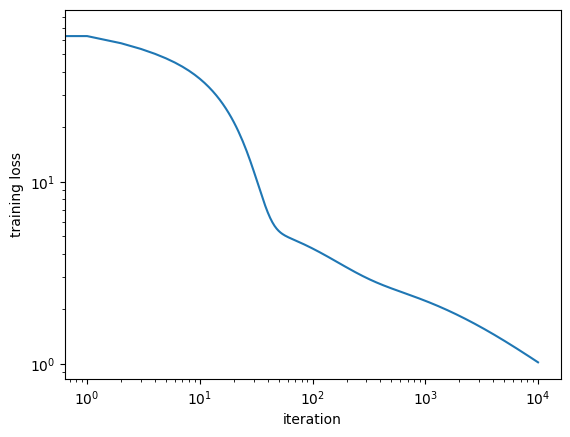

In [226]:
# TODO
# Jgd = ...
# plot(...)
Jgd=np.zeros(10000)
fun=Fun(xtr,ytr,d)
wt=winit
step=1e-3
for it in range(10000):
    Jgd[it],Jgrad=fun.Jeval(wt)
    wt=wt-step*Jgrad

plt.plot(Jgd)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.yscale('log')
plt.xscale('log')

Now try to get a faster convergence using adaptive step-size via the Armijo rule. Implement Armijo gradient descent.  Let `Jadapt[it]` be the loss value that it attains on iteration `it`.  Plot `Jadapt[it]` and `Jgd[it]` vs. `it` on the same log-log graph.  You should see some improvement.

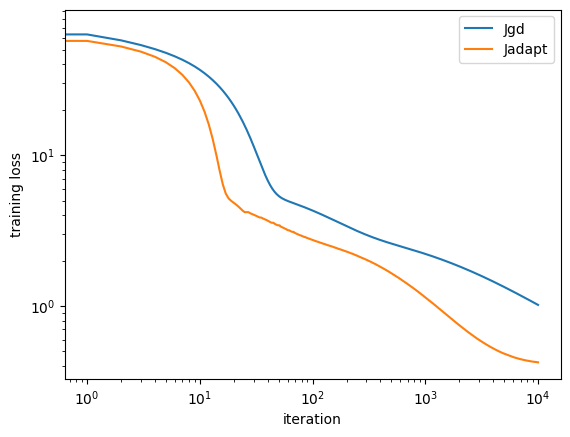

In [227]:
# TODO
# Jadapt = ...
# plot(...)
Jadapt=np.zeros(10000)
w0=winit
alpha=1e-3
J0,Jgrad0=fun.Jeval(w0)
for it in range(10000):
    w1=w0-alpha*Jgrad0
    J1,Jgrad1=fun.Jeval(w1)
    c=0.5
    beta_incr=1.1
    beta_decr=0.5
    if (J1-J0 < -c*alpha*(Jgrad0.dot(w1-w0)**2)):
        alpha = beta_incr*alpha
        J0 = J1
        Jgrad0 = Jgrad1
        w0 = w1
    else:
        w1=w0
        alpha = beta_decr*alpha
    Jadapt[it] = J0

plt.plot(Jgd,label='Jgd')
plt.plot(Jadapt,label='Jadapt')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.yscale('log')
plt.xscale('log')

Next, plot the predicted value of `yhat` vs. `x` for the grid of 1000 values of `x` in `[0,1]`, for three types of prediction `w` weights:
* the linearized initialization `winit`
* the gradient-descent solution for `w`
* the Armijo solution for `w`
  
Also, superimpose the test data points `(yts,xts)`.

Text(0, 0.5, 'Temperature y (K)')

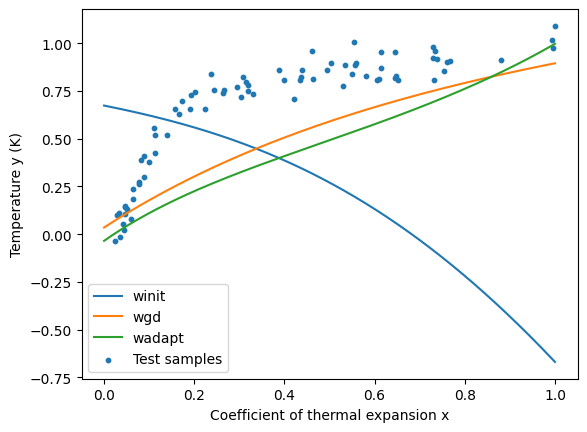

In [228]:
# TODO
# plot(...)
xp=np.linspace(0,1,1000)
yhat_init=predict(winit,xp)
yhat_gd=predict(wt,xp)
yhat_adapt=predict(w0,xp)
plt.plot(xp,yhat_init,label='winit')
plt.plot(xp,yhat_gd,label='wgd')
plt.plot(xp,yhat_adapt,label='wadapt')
plt.scatter(xts,yts,s=10,label='Test samples')
plt.legend()
plt.xlabel('Coefficient of thermal expansion x')
plt.ylabel('Temperature y (K)')

Finally, compute and print the RSS on the test fold for the three types of `w` vector listed above. Do the results make sense?

In [229]:
# TODO
# RSS_test_init = ...
# RSS_test_gd = ...
# RSS_test_adapt = ...
# print('RSS_test_init =',RSS_test_init)
# print('RSS_test_gd =',RSS_test_gd)
# print('RSS_test_adapt =',RSS_test_adapt)
yhat_init_test = predict(winit, xts)
yhat_gd_test = predict(wt, xts)
yhat_adapt_test = predict(w0, xts)

RSS_test_init = np.sum((yhat_init_test-yts)**2)
RSS_test_gd = np.sum((yhat_gd_test-yts)**2)
RSS_test_adapt = np.sum((yhat_adapt_test-yts)**2)
print('RSS_test_init =',RSS_test_init)
print('RSS_test_gd =',RSS_test_gd)
print('RSS_test_adapt =',RSS_test_adapt)

RSS_test_init = 34.72868114163378
RSS_test_gd = 5.1314635284014125
RSS_test_adapt = 8.235021531329107
